**Problem Statement**

The problem here is to recommend movies to users based on its already watched or searched history, also scrap reviews for that particular movie from IMDB and show few of the reviews and mention alongside which one of them are positive and which one of them are negative.

**Plan of Action**

The project will be divided into 2 parts:-

1.   First part deals with data preprocessing, creating of proper csv data file and recommending movies to user based on cosine similarity
2.   The second part deals with scrapping of reviews for that 
particular movie from IMDB and displaying a few of the reviews alongside telling wheather the review given by that particular reviews is positive or negative, this is basically sentiment analysis using Natural Language Processing (NLP).

**Dataset**

The dataset is taken from Kaggle, Wikepedia and IMDB from below mentioned links.

*   https://www.kaggle.com/carolzhangdcimdb-5000-movie-dataset
*   https://www.kaggle.com/rounakbanik/the-movies-dataset
*   https://www.kaggle.com/rounakbanik/the-movies-dataset?select=ratings_small.csv
*   https://en.wikipedia.org/wiki/List_of_American_films_of_2018
*   https://en.wikipedia.org/wiki/List_of_American_films_of_2019
*   https://en.wikipedia.org/wiki/List_of_American_films_of_2020









**How Cosine Similarity works?**

Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.

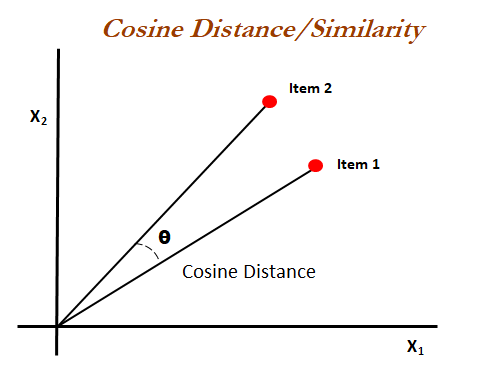

**Preprocessing Data**

The data is not well managed and we have to do a lot preprocessing and then convert it to proper csv file before being used for recommendation.

# Step 1 - Importing the Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# Step 2 - Importing the Datasets

In [5]:
data = pd.read_csv('/content/drive/My Drive/Data Science Projects/dataset_movies/movie_metadata.csv')
credit = pd.read_csv('/content/drive/My Drive/Data Science Projects/dataset_movies/credits.csv')
meta = pd.read_csv('/content/drive/My Drive/Data Science Projects/dataset_movies/movies_metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Step 3 - Working on data file

In [6]:
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


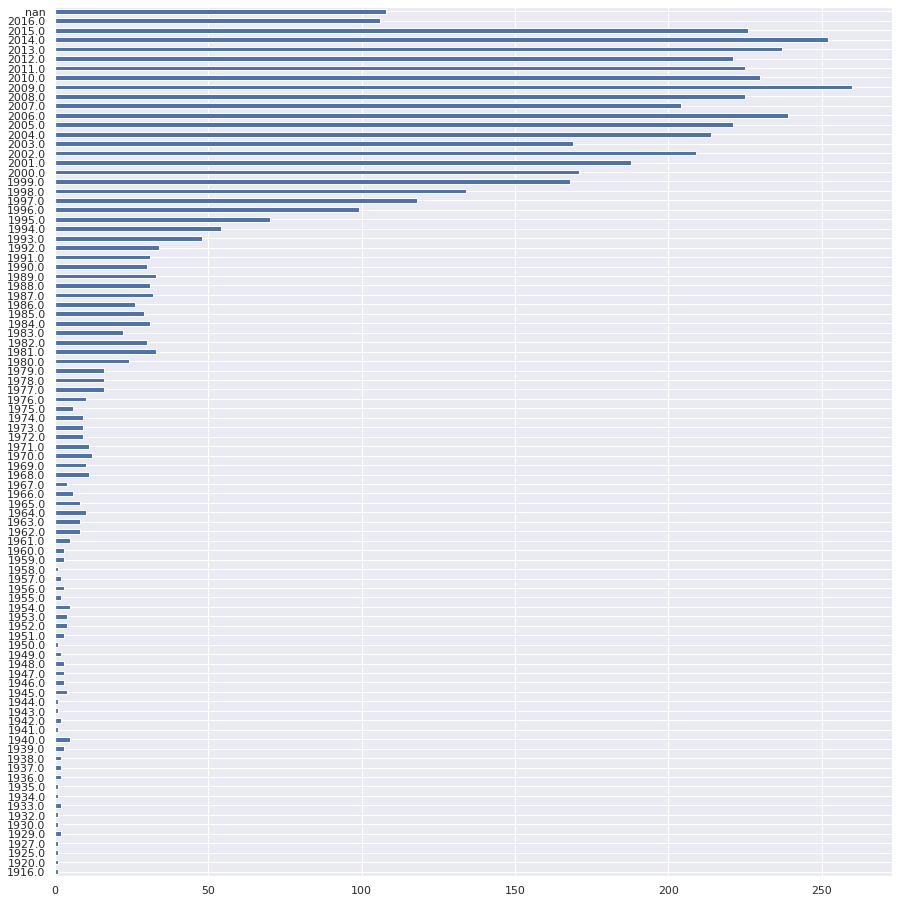

In [7]:
# Checking which year has how many number of movies

title_year = data['title_year'].value_counts(dropna =False).sort_index()
plt.figure( figsize = (15, 16))
title_year.plot(kind = 'barh')



In [8]:
# Dealing with Null values

data = data.loc[:, ['director_name','actor_1_name','actor_2_name','actor_3_name','genres','movie_title']]
totalnull = data.isnull().sum() 
print(totalnull)

director_name    104
actor_1_name       7
actor_2_name      13
actor_3_name      23
genres             0
movie_title        0
dtype: int64


In [9]:
data.dropna(inplace = True) 
totalnull = data.isnull().sum() 
print(totalnull)

director_name    0
actor_1_name     0
actor_2_name     0
actor_3_name     0
genres           0
movie_title      0
dtype: int64


In [10]:
# Checking some information of data

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4919 entries, 0 to 5042
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   director_name  4919 non-null   object
 1   actor_1_name   4919 non-null   object
 2   actor_2_name   4919 non-null   object
 3   actor_3_name   4919 non-null   object
 4   genres         4919 non-null   object
 5   movie_title    4919 non-null   object
dtypes: object(6)
memory usage: 269.0+ KB


In [11]:
# Removing extra space and lowering down characters

data['genres'] = data['genres'].str.replace('|', ' ')  # Replacing | with space
data['movie_title'] = data['movie_title'].str.lower()  # Lower down the characters of movie_title

print(data['movie_title'][0][-1])   # Movie title has extra space
print(data['genres'][1])
print(data['director_name'][1])
print(data['actor_1_name'][1])

data['movie_title'] = data['movie_title'].apply(lambda x : x[:-1]) # Removing the extra space
data.head()

 
Action Adventure Fantasy
Gore Verbinski
Johnny Depp


,director_name,actor_1_name,actor_2_name,actor_3_name,genres,movie_title
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action Adventure Fantasy Sci-Fi,avatar
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action Adventure Fantasy,pirates of the caribbean: at world's end
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action Adventure Thriller,spectre
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action Thriller,the dark knight rises
5,Andrew Stanton,Daryl Sabara,Samantha Morton,Polly Walker,Action Adventure Sci-Fi,john carter


# Step 2 - Working on Metadata

In [12]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [13]:
# Preprocessing meta

meta['release_date'] = pd.to_datetime(meta['release_date'], errors = 'coerce')
meta['year'] = meta['release_date'].dt.year

year = meta['year'].value_counts().sort_index()

In [14]:
# Now we will be taking out data for 2017 from meta

meta = meta.loc[meta.year==2017, ['genres','id','title','year']]

meta['id'] = meta['id'].astype(int)
meta.head()

,genres,id,title,year
26560,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017.0
26561,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",141052,Justice League,2017.0
26565,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",284053,Thor: Ragnarok,2017.0
26566,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",283995,Guardians of the Galaxy Vol. 2,2017.0
30536,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",245842,The King's Daughter,2017.0


In [15]:
# Merging meta and credit

merged = pd.merge(meta, credit, on = 'id')

In [16]:
merged.head()

,genres,id,title,year,cast,crew
0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017.0,"[{'cast_id': 1, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4c9cc3a36847f8236a65', 'de..."
1,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",141052,Justice League,2017.0,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '55ef66dbc3a3686f1700a52d', 'de..."
2,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",284053,Thor: Ragnarok,2017.0,"[{'cast_id': 0, 'character': 'Thor Odinson', '...","[{'credit_id': '56a93fa4c3a36872db001e7a', 'de..."
3,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",283995,Guardians of the Galaxy Vol. 2,2017.0,"[{'cast_id': 3, 'character': 'Peter Quill / St...","[{'credit_id': '59171547925141583c0315a6', 'de..."
4,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",245842,The King's Daughter,2017.0,"[{'cast_id': 0, 'character': 'King Louis XIV',...","[{'credit_id': '5431de49c3a36825d300007e', 'de..."


In [17]:
#Converting string to list of merged

import ast 

merged['genres'] = merged['genres'].map(lambda x : ast.literal_eval(x))
merged['cast'] = merged['cast'].map(lambda x : ast.literal_eval(x))
merged['crew'] = merged['crew'].map(lambda x : ast.literal_eval(x))

In [18]:
# Working on merged genres

def make_genreslist(x):
  gen = []
  string = " "
  
  for i in x:
    if(i.get('name')=='Science Fiction'):
      gen.append('Sci-Fi')
    else:
      gen.append(i.get('name'))
  
  if (gen == []):
    return np.nan
  else:
    return string.join(gen)

merged['genres'] = merged['genres'].map(lambda x: (make_genreslist(x)))
merged.head()

,genres,id,title,year,cast,crew
0,Adventure Action Fantasy Comedy,166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017.0,"[{'cast_id': 1, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4c9cc3a36847f8236a65', 'de..."
1,Action Adventure Fantasy Sci-Fi,141052,Justice League,2017.0,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '55ef66dbc3a3686f1700a52d', 'de..."
2,Action Adventure Fantasy Sci-Fi,284053,Thor: Ragnarok,2017.0,"[{'cast_id': 0, 'character': 'Thor Odinson', '...","[{'credit_id': '56a93fa4c3a36872db001e7a', 'de..."
3,Action Adventure Comedy Sci-Fi,283995,Guardians of the Galaxy Vol. 2,2017.0,"[{'cast_id': 3, 'character': 'Peter Quill / St...","[{'credit_id': '59171547925141583c0315a6', 'de..."
4,Fantasy Action Adventure,245842,The King's Daughter,2017.0,"[{'cast_id': 0, 'character': 'King Louis XIV',...","[{'credit_id': '5431de49c3a36825d300007e', 'de..."


In [19]:
# Working on merged cast column

def get_actor1(x):
  actors = []
  string = " "
  
  for i in x:
    actors.append(i.get('name'))
  
  if (actors == []):
    return np.nan
  else:
    return string.join(actors[0])

def get_actor2(x):
  actors = []
  string = " "
  
  for i in x:
    actors.append(i.get('name'))
  
  if (actors == [] or len(actors)<=1):
    return np.nan
  else:
    return string.join(actors[1])

def get_actor3(x):
  actors = []
  string = " "
  
  for i in x:
    actors.append(i.get('name'))
  
  if (actors == [] or len(actors)<=2):
    return np.nan
  else:
    return string.join(actors[2])


merged['actor_1_name'] = merged['cast'].map(lambda x: (get_actor1(x)))
merged['actor_2_name'] = merged['cast'].map(lambda x: (get_actor2(x)))
merged['actor_3_name'] = merged['cast'].map(lambda x: (get_actor3(x)))
merged.head()


,genres,id,title,year,cast,crew,actor_1_name,actor_2_name,actor_3_name
0,Adventure Action Fantasy Comedy,166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017.0,"[{'cast_id': 1, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4c9cc3a36847f8236a65', 'de...",J o h n n y D e p p,J a v i e r B a r d e m,G e o f f r e y R u s h
1,Action Adventure Fantasy Sci-Fi,141052,Justice League,2017.0,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '55ef66dbc3a3686f1700a52d', 'de...",B e n A f f l e c k,H e n r y C a v i l l,G a l G a d o t
2,Action Adventure Fantasy Sci-Fi,284053,Thor: Ragnarok,2017.0,"[{'cast_id': 0, 'character': 'Thor Odinson', '...","[{'credit_id': '56a93fa4c3a36872db001e7a', 'de...",C h r i s H e m s w o r t h,T o m H i d d l e s t o n,C a t e B l a n c h e t t
3,Action Adventure Comedy Sci-Fi,283995,Guardians of the Galaxy Vol. 2,2017.0,"[{'cast_id': 3, 'character': 'Peter Quill / St...","[{'credit_id': '59171547925141583c0315a6', 'de...",C h r i s P r a t t,Z o e S a l d a n a,D a v e B a u t i s t a
4,Fantasy Action Adventure,245842,The King's Daughter,2017.0,"[{'cast_id': 0, 'character': 'King Louis XIV',...","[{'credit_id': '5431de49c3a36825d300007e', 'de...",P i e r c e B r o s n a n,W i l l i a m H u r t,B e n j a m i n W a l k e r


In [20]:
# Working on merged crew column

def get_directors(x):
  directors = []
  string = " "
  
  for i in x:
    if(i.get('job') == 'Director'):
      directors.append(i.get('name'))
  
  if (directors == [] ):
    return np.nan
  else:
    return string.join(directors)
  
merged['director_name'] = merged['crew'].map(lambda x: (get_directors(x)))
merged.head()

,genres,id,title,year,cast,crew,actor_1_name,actor_2_name,actor_3_name,director_name
0,Adventure Action Fantasy Comedy,166426,Pirates of the Caribbean: Dead Men Tell No Tales,2017.0,"[{'cast_id': 1, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4c9cc3a36847f8236a65', 'de...",J o h n n y D e p p,J a v i e r B a r d e m,G e o f f r e y R u s h,Joachim Rønning Espen Sandberg
1,Action Adventure Fantasy Sci-Fi,141052,Justice League,2017.0,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '55ef66dbc3a3686f1700a52d', 'de...",B e n A f f l e c k,H e n r y C a v i l l,G a l G a d o t,Zack Snyder
2,Action Adventure Fantasy Sci-Fi,284053,Thor: Ragnarok,2017.0,"[{'cast_id': 0, 'character': 'Thor Odinson', '...","[{'credit_id': '56a93fa4c3a36872db001e7a', 'de...",C h r i s H e m s w o r t h,T o m H i d d l e s t o n,C a t e B l a n c h e t t,Taika Waititi
3,Action Adventure Comedy Sci-Fi,283995,Guardians of the Galaxy Vol. 2,2017.0,"[{'cast_id': 3, 'character': 'Peter Quill / St...","[{'credit_id': '59171547925141583c0315a6', 'de...",C h r i s P r a t t,Z o e S a l d a n a,D a v e B a u t i s t a,James Gunn
4,Fantasy Action Adventure,245842,The King's Daughter,2017.0,"[{'cast_id': 0, 'character': 'King Louis XIV',...","[{'credit_id': '5431de49c3a36825d300007e', 'de...",P i e r c e B r o s n a n,W i l l i a m H u r t,B e n j a m i n W a l k e r,Sean McNamara


In [21]:
# Dropping columns from merged which are not needed and preprocessing further

merged = merged.loc[:,['director_name', 'actor_1_name', 'actor_2_name','actor_3_name','genres','title']]

merged.dropna(inplace=True) #Dropping na columns

merged = merged.rename(columns={'title':'movie_title'})

merged['movie_title'] = merged['movie_title'].str.lower()

merged.head()

,director_name,actor_1_name,actor_2_name,actor_3_name,genres,movie_title
0,Joachim Rønning Espen Sandberg,J o h n n y D e p p,J a v i e r B a r d e m,G e o f f r e y R u s h,Adventure Action Fantasy Comedy,pirates of the caribbean: dead men tell no tales
1,Zack Snyder,B e n A f f l e c k,H e n r y C a v i l l,G a l G a d o t,Action Adventure Fantasy Sci-Fi,justice league
2,Taika Waititi,C h r i s H e m s w o r t h,T o m H i d d l e s t o n,C a t e B l a n c h e t t,Action Adventure Fantasy Sci-Fi,thor: ragnarok
3,James Gunn,C h r i s P r a t t,Z o e S a l d a n a,D a v e B a u t i s t a,Action Adventure Comedy Sci-Fi,guardians of the galaxy vol. 2
4,Sean McNamara,P i e r c e B r o s n a n,W i l l i a m H u r t,B e n j a m i n W a l k e r,Fantasy Action Adventure,the king's daughter


# Step 3 - Combining merged and data in a single data frame and exporting to csv

In [22]:
data['comb'] = data['director_name'] + ' ' + data['actor_1_name'] + ' ' + data['actor_2_name'] + ' ' + data['actor_3_name'] + ' ' + data['genres']

merged['comb'] = merged['director_name'] + ' ' + merged['actor_1_name'] + ' ' + merged['actor_2_name'] + ' ' + merged['actor_3_name'] + ' ' + merged['genres']

complete = data.append(merged)

complete.drop_duplicates(subset = 'movie_title', keep = 'last', inplace = True)

complete.to_csv('complete.csv', index = False) # Exporting to csv for further use and processing

In [23]:
complete.head()

,director_name,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,comb
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action Adventure Fantasy Sci-Fi,avatar,James Cameron CCH Pounder Joel David Moore Wes...
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action Adventure Fantasy,pirates of the caribbean: at world's end,Gore Verbinski Johnny Depp Orlando Bloom Jack ...
2,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,Action Adventure Thriller,spectre,Sam Mendes Christoph Waltz Rory Kinnear Stepha...
3,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action Thriller,the dark knight rises,Christopher Nolan Tom Hardy Christian Bale Jos...
5,Andrew Stanton,Daryl Sabara,Samantha Morton,Polly Walker,Action Adventure Sci-Fi,john carter,Andrew Stanton Daryl Sabara Samantha Morton Po...
